In [1]:

import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import math

import os

from global_config import config
import matplotlib.pyplot as plt

results_dir = config.get_property('results_dir')


In [2]:
import numpy as np

def eakf_step(x_prior, params_prior, obs_ens_time, obs_time, oev_time, dict_params_range, num_var=8):

    prior_mean_ct = obs_ens_time.mean()
    prior_var_ct  = obs_ens_time.var()

    if prior_mean_ct == 0:
        post_var_ct  = 1e-3
        prior_var_ct = 1e-3

    post_var_ct  = prior_var_ct * oev_time / (prior_var_ct + oev_time)
    post_mean_ct = post_var_ct * (prior_mean_ct/prior_var_ct + obs_time / oev_time)
    alpha        = oev_time / (oev_time+prior_var_ct); alpha = alpha**0.5
    dy           = post_mean_ct + alpha*( obs_ens_time - prior_mean_ct ) - obs_ens_time

    # adjust parameters
    rr = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        A = np.cov(params_prior[idx_p,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr         = np.array(rr)
    dx         = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
    param_post = params_prior + dx

    # adjust variables
    rr = []
    for idx_var in range(num_var):
        A = np.cov(x_prior[idx_var,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr       = np.array(rr)
    dx       = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
    x_post   = x_prior + dx

    obs_post    = obs_ens_time + dy

    return x_post, param_post, obs_post

def checkbound_params_old(dict_params_range, params_ens, num_ensembles=300):

    params_update = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        loww = dict_params_range[p][0]
        upp  = dict_params_range[p][1]

        p_ens = params_ens[idx_p, :].copy()

        idx_wrong = np.where(np.logical_or(p_ens <loww, p_ens > upp))[0]
        idx_good  = np.where(np.logical_or(p_ens >=loww, p_ens <= upp))[0]


        p_ens[idx_wrong] = np.median(p_ens[idx_good])
        params_update.append(p_ens)

        print(f"{p}: {np.median(p_ens)}")

    return np.array(params_update)

def checkbound_params(dict_params_range, params_ens, num_ensembles=300):
    params_update = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        loww = dict_params_range[p][0]
        upp  = dict_params_range[p][1]

        p_ens = params_ens[idx_p, :].copy()

        idx_wrong      = np.where(np.logical_or(p_ens <loww, p_ens > upp))[0]

        idx_wrong_loww = np.where(p_ens < loww)[0]
        idx_wrong_upp  = np.where(p_ens > upp)[0]

        idx_good  = np.where(np.logical_or(p_ens >=loww, p_ens <= upp))[0]

        p_ens[idx_wrong] = np.median(p_ens[idx_good])

        np.put(p_ens, idx_wrong_loww, loww * (1+0.2*np.random.rand( idx_wrong_loww.shape[0])) )
        np.put(p_ens, idx_wrong_upp, upp * (1-0.2*np.random.rand( idx_wrong_upp.shape[0])) )

        params_update.append(p_ens)

    return np.array(params_update)

def checkbound_state_vars(x_state_ens, pop, num_params=8, num_ensembles=300):
    loww = 0
    upp  = pop
    x_state_ens = np.clip(x_state_ens, 0, upp)
    return x_state_ens

def inflate_ensembles(ens, inflation_value=1.2, num_ensembles=300):
    return np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)) + inflation_value*(ens-np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)))

def b_transition(var, rate, dt=1):
    kb        = np.maximum(1.0 - math.exp(-rate*dt), 0)
    num_ind   = np.random.binomial(var, kb )

    return num_ind

def model(x, beta, gamma, report_rate=0.2, N=1e6):

    S   = x[0]   # Susceptibles
    I   = x[1]   # Infected Reported
    R   = x[2]   # Recovered

    foi =  beta * (I) / N

    # Stochastic transitions
    s2i     =  b_transition(S, foi)                 # susceptible to exposed
    i2r     =  b_transition(I, gamma) # exposed to infected reported who are not going to die

    # Updates
    S    = S   - s2i       # Susceptible
    I    = I   + s2i - i2r  # Infected reported
    R    = R   + i2r       # Recovered
    C    = np.random.binomial(s2i, report_rate)

    return [S, I, R, C]


In [3]:
from scipy.stats import truncnorm
import numpy as np


def sample_params_uniform(dict_params_range, num_ensembles=100):
    param_ens_prior = []
    for p in dict_params_range.keys():
        param_ens_prior.append( np.random.uniform( dict_params_range[p][0], dict_params_range[p][1]  , size=num_ensembles) )
    return np.array( param_ens_prior )

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm( (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd )

def sample_params_normal(dict_params_range, params_mean, params_var, num_ensembles=300):
    param_ens_prior = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        norm_gen = get_truncated_normal(mean=params_mean[idx_p], sd=params_var[idx_p]**(1/2), low=dict_params_range[p][0], upp=dict_params_range[p][1])

        param_ens_prior.append( norm_gen.rvs(num_ensembles) )

    return np.array( param_ens_prior )

def create_df_response(samples, time, date_init ='2020-03-06',  quantiles = [50, 80, 95], forecast_horizon=27, dates=None, use_future=False):
    """[summary]

    Args:
        samples ([type]): [description]
        time ([type]): [description]
        date_init (str, optional): [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """
    if dates is not None:
        dates_fitted = dates
    else:
        dates_fitted   = pd.date_range(start=pd.to_datetime(date_init), periods=time)
        dates_forecast = pd.date_range(start=dates_fitted[-1]+datetime.timedelta(1), periods=forecast_horizon)

    dates = list(dates_fitted)
    types = ['estimate']*len(dates_fitted)
    if use_future:
        dates += list(dates_forecast)
        types  += ['forecast']*len(dates_forecast)

    results_df = pd.DataFrame(samples.T)
    df_response = pd.DataFrame(index=dates)
    # Calculate key statistics
    df_response['mean']        = results_df.mean(axis=1).values
    df_response['median']      = results_df.median(axis=1).values
    df_response['std']         = results_df.std(axis=1).values

    for quant in quantiles:
        low_q  = ((100-quant)/2)/100
        high_q = 1-low_q

        df_response[f'low_{quant}']  = results_df.quantile(q=low_q, axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q, axis=1).values

    df_response['type']        =  types
    df_response.index.name = 'date'

    return df_response


In [4]:
import numpy as np


def eakf_step(x_prior, params_prior, obs_ens_time, obs_time, oev_time, dict_params_range, num_var=4):

    prior_mean_ct = obs_ens_time.mean()
    prior_var_ct  = obs_ens_time.var()

    if prior_mean_ct == 0:
        post_var_ct  = 1e-3
        prior_var_ct = 1e-3


    post_var_ct  = prior_var_ct * oev_time / (prior_var_ct + oev_time)
    post_mean_ct = post_var_ct * (prior_mean_ct/prior_var_ct + obs_time / oev_time)
    alpha        = oev_time / (oev_time+prior_var_ct); alpha = alpha**0.5
    dy           = post_mean_ct + alpha*( obs_ens_time - prior_mean_ct ) - obs_ens_time

    # adjust parameters
    rr = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        A = np.cov(params_prior[idx_p,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr         = np.array(rr)
    dx         = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
    param_post = params_prior + dx

    # adjust variables
    rr = []
    for idx_var in range(num_var):
        A = np.cov(x_prior[idx_var,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr       = np.array(rr)
    dx       = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
    x_post   = x_prior + dx

    obs_post    = obs_ens_time + dy

    return x_post, param_post, obs_post

def checkbound_params_old(dict_params_range, params_ens, num_ensembles=300):

    params_update = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        loww = dict_params_range[p][0]
        upp  = dict_params_range[p][1]

        p_ens = params_ens[idx_p, :].copy()

        idx_wrong = np.where(np.logical_or(p_ens <loww, p_ens > upp))[0]
        idx_good  = np.where(np.logical_or(p_ens >=loww, p_ens <= upp))[0]


        p_ens[idx_wrong] = np.median(p_ens[idx_good])
        params_update.append(p_ens)

        print(f"{p}: {np.median(p_ens)}")

    return np.array(params_update)

def checkbound_params(dict_params_range, params_ens, num_ensembles=300):
    params_update = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        loww = dict_params_range[p][0]
        upp  = dict_params_range[p][1]

        p_ens = params_ens[idx_p, :].copy()

        idx_wrong      = np.where(np.logical_or(p_ens <loww, p_ens > upp))[0]

        idx_wrong_loww = np.where(p_ens < loww)[0]
        idx_wrong_upp  = np.where(p_ens > upp)[0]

        idx_good  = np.where(np.logical_or(p_ens >=loww, p_ens <= upp))[0]

        p_ens[idx_wrong] = np.median(p_ens[idx_good])

        np.put(p_ens, idx_wrong_loww, loww * (1+0.2*np.random.rand( idx_wrong_loww.shape[0])) )
        np.put(p_ens, idx_wrong_upp, upp * (1-0.2*np.random.rand( idx_wrong_upp.shape[0])) )

        params_update.append(p_ens)

    return np.array(params_update)

def checkbound_state_vars(x_state_ens, pop, num_params=8, num_ensembles=300):
    loww = 0
    upp  = pop
    x_state_ens = np.clip(x_state_ens, 0, upp)
    return x_state_ens

def inflate_ensembles(ens, inflation_value=1.2, num_ensembles=300):
    return np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)) + inflation_value*(ens-np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)))


# Hints and Misc:
https://kingaa.github.io/sbied/mif/if2_settings.html


- It is generally helpful to transform the parameters so that (on the estimation scale) they are real-valued, unconstrained, and have uncertainty on the order of 1 unit. 
    - Real positive value parameters estimated on log scale.
    - Parameters in the range [0,1] estimated using a logistic transformation


In [5]:
# Transformation of parameters.

def logistic_transform(param_ensemble, destransform=False):
    if ~ destransform:
        # Return transformed parameters
        return np.log(param_ensemble/(1-param_ensemble))

    elif destransform:
        # Return destransformed parameters
        return 1/(1/np.exp(param_ensemble)+1)

def log_transform(param_ensemble, destransform=False):
    if ~ destransform:
        # Return transformed parameters
        return np.log(param_ensemble)
    elif destransform:
        return np.exp(param_ensemble)

def random_walk_perturbation(param, param_std, num_params, num_ensembles):
    return param + param_std * np.random.normal(size=(num_params, num_ensembles))

In [9]:
def geometric_cooling(num_iteration_if, cooling_factor=0.9):
    alphas = cooling_factor**np.arange(num_iteration_if)
    return alphas**2

def hyperbolic_cooling(num_iteration_if, cooling_factor=0.9):
    alphas = 1/(1+cooling_factor*np.arange(num_iteration_if))
    return alphas

def cooling(num_iteration_if, type_cool="geometric", cooling_factor=0.9):
    if type_cool=="geometric":
        return geometric_cooling(num_iteration_if, cooling_factor=cooling_factor)
    elif type_cool=="hyperbolic":
        return hyperbolic_cooling(num_iteration_if, cooling_factor=cooling_factor)



from tqdm import tqdm

def IF2_eakf(model, obs_df, param_prior_dict, if2_settings, perturb_time=False):

    cooling_factor   = cooling(if2_settings["num_iters_mif"], type_cool=if2_settings["type_cooling"], cooling_factor=if2_settings["alpha_mif"])

    param_range      = np.array([v for k, v in param_prior_dict.items()])
    std_param        = param_range[:,1]-param_range[:,0]
    SIG              = std_param ** 2 / 4; #  initial covariance of parameters

    perturbation     = np.array([std_param % list(np.round(std_param)+0.1)]).T

    num_steps          = len(obs_df) -1


    x_states_post_all  = np.full((if2_settings["num_state_vars"],   if2_settings["num_ensembles"], num_steps, if2_settings["num_iters_mif"]), np.nan)   # Array to store state variables.
    param_mean_iter    = np.full((if2_settings["num_params"],       if2_settings["num_iters_mif"]+1), np.nan)                               # Array to store posterior parameters in iterations.
    para_post_all      = np.full((if2_settings["num_params"],       if2_settings["num_ensembles"], num_steps, if2_settings["num_iters_mif"]), np.nan)       # Array to store posterior parameters.
    obs_post_all       = np.full((if2_settings["num_observations"], if2_settings["num_ensembles"], num_steps, if2_settings["num_iters_mif"]), np.nan) # Array for store posterior observations
    param_iter         = np.full((if2_settings["num_params"],       if2_settings["num_ensembles"], if2_settings["num_iters_mif"]), np.nan)

    dates_assimilation = obs_df.index.get_level_values(0).values
    dates              = dates_assimilation
    print(f"Running MIF  \n")

    for n in tqdm(range(if2_settings["num_iters_mif"])):
        if n==0:
            p_prior               = sample_params_uniform(param_prior_dict, num_ensembles=if2_settings["num_ensembles"])
            x                     = np.array([[N-0.01*N, 0.01*N, 0, 0.01*N]]).T * np.ones((if2_settings["num_state_vars"], if2_settings["num_ensembles"]))
            param_mean_iter[:, n] = np.mean(p_prior, -1)

        else:
            params_mean     = param_mean_iter[:,n]
            params_var      = SIG * cooling_factor[n]
            p_prior         = sample_params_normal(param_prior_dict, params_mean, params_var, num_ensembles=if2_settings["num_ensembles"])
            x               = np.array([[N-0.01*N, 0.01*N, 0, 0.01*N]]).T * np.ones((4, if2_settings["num_ensembles"]))

        param_post_time   = np.full((if2_settings["num_params"], if2_settings["num_ensembles"], num_steps), np.nan)
        x_post_time       = np.full((if2_settings["num_state_vars"], if2_settings["num_ensembles"], num_steps), np.nan)
        obs_post_time     = np.full((if2_settings["num_observations"], if2_settings["num_ensembles"], num_steps), np.nan)

        idx_date_update   = 0


        confirmed_t = np.zeros((if2_settings["num_ensembles"], 1))
        for idx_t, date in enumerate(dates[1:]):
            # Integrate model
            x_ens =[]
            for idx_ens in range(if2_settings["num_ensembles"]):
                beta        = p_prior[0, idx_ens]
                gamma       = p_prior[1, idx_ens]
                report_rate = p_prior[2, idx_ens]
                x_ens.append(model(x[:,idx_ens], beta, gamma, report_rate, N))
            x_ens = np.array(x_ens).T
            x     = x_ens

            # Inflate state variables
            x = inflate_ensembles(x, inflation_value=if2_settings["lambda_inf"], num_ensembles=if2_settings["num_ensembles"])
            x = checkbound_state_vars(x_state_ens=x, pop=N, num_params=if2_settings["num_params"], num_ensembles=if2_settings["num_ensembles"])

            if perturb_time:
                # Transform parameters for perturbation
                #p_prior    = log_transform(p_prior, destransform=False)
                std_params = perturbation*cooling_factor[n]
                p_prior    = random_walk_perturbation(p_prior, std_params, if2_settings["num_params"], if2_settings["num_ensembles"])
                #p_prior    = log_transform(p_prior, destransform=True)

            # Inflate parameters
            p_prior = inflate_ensembles(p_prior, inflation_value=if2_settings["lambda_inf"], num_ensembles=if2_settings["num_ensembles"])
            p_prior = checkbound_params(param_prior_dict, p_prior, num_ensembles=if2_settings["num_ensembles"])

            confirmed_t  +=  np.expand_dims(x[-1,:], -1)

            if pd.to_datetime(date) == pd.to_datetime(dates_assimilation[1:][idx_date_update]):
                    oev_confirmed_time = oev_df.loc[date]["oev"]

                    confirmed_time = obs_df.loc[date]["confirmed"]

                    param_post = p_prior.copy()
                    # Update parameters using confirmed deaths
                    x_prior = x.copy()
                    x_post, param_post, confirmed_obs_post = eakf_step(x, param_post, np.squeeze(confirmed_t), confirmed_time, oev_confirmed_time, param_prior_dict)

                    x_post                                 = checkbound_state_vars(x_state_ens=x_post, pop=N, num_params=if2_settings["num_state_vars"], num_ensembles=if2_settings["num_ensembles"])
                    param_post                             = checkbound_params(param_prior_dict, params_ens=param_post, num_ensembles=if2_settings["num_ensembles"])

                    #if np.where(param_post==np.nan)
                    x       = x_post.copy()
                    # Use posterior and next prior
                    p_prior = param_post.copy()

                    obs_post_time[:,:,idx_date_update]    = confirmed_obs_post
                    param_post_time[:,:,idx_date_update]  = param_post
                    x_post_time[:,:,idx_date_update]      = x_post

                    idx_date_update += 1

                    confirmed_t = np.zeros((if2_settings["num_ensembles"], 1))

        x_states_post_all  = x_post_time
        #np.put(x_states_post_all, [:,:,:,n], x_post_time )

        obs_post_all[:,:,:,n]       = obs_post_time
        para_post_all[:,:,:,n]      = param_post_time
        param_iter[:,:,n]           = param_post_time.mean(-1)
        param_mean_iter[:,n+1]      = param_post_time.mean(-1).mean(-1)

    return x_states_post_all, obs_post_all, para_post_all, param_iter, param_mean_iter

plt.rc('font', size=15) #controls default text size

def plot_convergence_plots(theta, param_iter, prior_range, path_to_save = None):
    ittters  = param_iter.shape[-1]
    beta_df  = create_df_response(param_iter[0,:,:], time=ittters)
    gamma_df = create_df_response(param_iter[1,:,:], time=ittters)

    beta_mle  = beta_df["mean"].iloc[-1]
    gamma_mle = gamma_df["mean"].iloc[-1]


    fig, ax = plt.subplots(2, 1, figsize=(12.5, 7.2), sharex=True)

    ax[0].plot(range(ittters+1), theta[0,:], color="k", lw=3, label="Mean")
    ax[0].fill_between(range(1,ittters+1), beta_df["low_95"], beta_df["high_95"], color="gray", alpha=0.3, label="95% CI")
    ax[0].fill_between(range(1,ittters+1), beta_df["low_50"], beta_df["high_50"], color="gray", alpha=0.3, label="50% CI")
    ax[0].axhline(y=beta_truth, color="red", linestyle="--", lw=2, label="Truth")

    ax[1].plot(range(ittters+1), theta[1,:], color="k", lw=3, label="Mean")
    ax[1].fill_between(range(1,ittters+1), gamma_df["low_95"], gamma_df["high_95"], color="gray", alpha=0.3, label="95% CI")
    ax[1].fill_between(range(1,ittters+1), gamma_df["low_50"], gamma_df["high_50"], color="gray", alpha=0.3, label="50% CI")

    ax[1].axhline(y=gamma_truth, color="red", linestyle="--", lw=2, label="Truth")

    ax[1].set_xlabel("IF2 Iteration")
    ax[0].set_ylabel(r"$\beta$")
    ax[1].set_ylabel(r"$\gamma$")

    ax[0].legend(loc="upper right")
    ax[1].legend(loc="upper right")

    for idx, axi in enumerate(ax):
        axi.set_ylim(prior_range[idx])

    fig.suptitle(r"$\mathcal{{R}}_0$={:0.1f}, $\beta=${:0.4f}, $\beta_{{MAP}}=${:0.4f} | $\gamma=${:0.4f}, $\gamma_{{MAP}}=${:0.4f}".format(beta_mle/gamma_mle, beta_truth, beta_mle, gamma_truth, gamma_mle))
    plt.tight_layout()
    if path_to_save:
        fig.savefig(path_to_save, dpi=300, transparent=True)


def plot_convergence_plots2(theta, param_iter, prior_range, path_to_save = None):
    ittters  = param_iter.shape[-1]
    beta_df  = create_df_response(param_iter[0,:,:], time=ittters)
    gamma_df = create_df_response(param_iter[1,:,:], time=ittters)
    alpha_df = create_df_response(param_iter[2,:,:], time=ittters)

    beta_mle  = beta_df["mean"].iloc[-1]
    gamma_mle = gamma_df["mean"].iloc[-1]
    report_rate_mle = alpha_df["mean"].iloc[-1]

    fig, ax = plt.subplots(3, 1, figsize=(12.5, 10.2), sharex=True)

    ax[0].plot(range(ittters+1), theta[0,:], color="k", lw=3, label="Mean")
    ax[0].fill_between(range(1,ittters+1), beta_df["low_95"], beta_df["high_95"], color="gray", alpha=0.3, label="95% CI")
    ax[0].fill_between(range(1,ittters+1), beta_df["low_50"], beta_df["high_50"], color="gray", alpha=0.3, label="50% CI")
    ax[0].axhline(y=beta_truth, color="red", linestyle="--", lw=2, label="Truth")

    ax[1].plot(range(ittters+1), theta[1,:], color="k", lw=3, label="Mean")
    ax[1].fill_between(range(1,ittters+1), gamma_df["low_95"], gamma_df["high_95"], color="gray", alpha=0.3, label="95% CI")
    ax[1].fill_between(range(1,ittters+1), gamma_df["low_50"], gamma_df["high_50"], color="gray", alpha=0.3, label="50% CI")
    ax[1].axhline(y=gamma_truth, color="red", linestyle="--", lw=2, label="Truth")

    ax[2].plot(range(ittters+1), theta[2,:], color="k", lw=3, label="Mean")
    ax[2].fill_between(range(1,ittters+1), alpha_df["low_95"], alpha_df["high_95"], color="gray", alpha=0.3, label="95% CI")
    ax[2].fill_between(range(1,ittters+1), alpha_df["low_50"], alpha_df["high_50"], color="gray", alpha=0.3, label="50% CI")
    ax[2].axhline(y=report_rate_truth, color="red", linestyle="--", lw=2, label="Truth")

    ax[1].set_xlabel("IF2 Iteration")
    ax[0].set_ylabel(r"$\beta$")
    ax[1].set_ylabel(r"$\gamma$")
    ax[2].set_ylabel(r"$\alpha$")

    ax[0].legend(loc="upper right")
    ax[1].legend(loc="upper right")
    ax[2].legend(loc="upper right")

    for idx, axi in enumerate(ax):
        axi.set_ylim(prior_range[idx])

    fig.suptitle(r"$\mathcal{{R}}_0$={:0.1f}, $\beta=${:0.4f}, $\beta_{{MAP}}=${:0.4f} | $\gamma=${:0.4f}, $\gamma_{{MAP}}=${:0.4f} | $\alpha=${:0.4f}, $\alpha_{{MAP}}=${:0.4f}".format(beta_mle/gamma_mle, beta_truth, beta_mle, gamma_truth, gamma_mle, report_rate_truth, report_rate_mle))
    plt.tight_layout()
    if path_to_save:
        fig.savefig(path_to_save, dpi=300, transparent=True)


In [1]:
r_ceros = [2.5, 5, 12]
gammas = [1/4, 1/7]
for R0 in r_ceros:
    for gamma in gammas:
        beta  = R0*gamma

        N     = 1e6

        beta_truth        = beta
        gamma_truth       = gamma
        report_rate_truth = 0.3

        num_days = 100
        x  = [N-0.01*N, 0.01*N, 0, 0]

        x_sol      = np.zeros((num_days, 4))

        x_sol[0, :] = x
        for d_idx in range(1, num_days):
            x_sol[d_idx, :] = model(x_sol[d_idx-1, :], beta, gamma, report_rate_truth,  N)

        x_sol_df = pd.DataFrame(x_sol, columns=["S", "I", "R", "C"]); x_sol_df.index.name="date"

        obs_df         = x_sol_df[["C"]].rename(columns={"C": "confirmed"})
        oev_df         = pd.DataFrame(columns=["date", "oev"])
        oev_df["date"] = obs_df.index.values
        oev_df         = oev_df.set_index("date")
        oev_df["oev"]  = np.maximum(20,  1+(0.2*obs_df["confirmed"].values)**2  )


        param_prior_dict          = {}
        param_prior_dict["beta"]  = [0.2, 3.5]   # Contact rate         [1/days]
        param_prior_dict["gamma"] = [1/15, 1/3]  # Recovery rate range  [1/days]
        param_prior_dict["gamma"] = [0.01, 1]    # Report rate

        params_type_dict  = {"beta": "log_transform", "gamma": "log_transform"} # Define type of transformation for estimate
        transform_dict    = {"beta": True, "gamma": True}                       # Define if tranform or nor parameters

        if2_settings = {}
        if2_settings["num_params"]       = len(param_prior_dict)
        if2_settings["num_state_vars"]   = 4
        if2_settings["num_observations"] = 1
        if2_settings["lambda_inf"]       = 1.01
        if2_settings["num_iters_mif"]    = 50
        if2_settings["alpha_mif"]        = 0.9 # Variance shrinking factor
        if2_settings["type_cooling"]     = "geometric"
        if2_settings["num_ensembles"]    = 300

        x_states_post_all, obs_post_all, para_post_all, param_iter, param_mean_iter = IF2_eakf(model, obs_df, param_prior_dict, if2_settings,  perturb_time=True)
        plot_convergence_plots(param_mean_iter, param_iter, list(param_prior_dict.values()), path_to_save = os.path.join(results_dir, "if2_eakf", "beta_{:.2f}_gamma_{:.2f}_reprate_{}.png".format(beta_truth, 1/gamma_truth, report_rate)))


NameError: name 'np' is not defined

  0%|          | 0/50 [00:00<?, ?it/s]

Running MIF  



  0%|          | 0/50 [00:00<?, ?it/s]

Running MIF  



  0%|          | 0/50 [00:00<?, ?it/s]

Running MIF  



  0%|          | 0/50 [00:00<?, ?it/s]

Running MIF  



  0%|          | 0/50 [00:00<?, ?it/s]

Running MIF  



  0%|          | 0/50 [00:00<?, ?it/s]

Running MIF  



  0%|          | 0/50 [00:00<?, ?it/s]

Running MIF  



  0%|          | 0/50 [00:00<?, ?it/s]

Running MIF  



  0%|          | 0/50 [00:00<?, ?it/s]

Running MIF  



  0%|          | 0/50 [00:00<?, ?it/s]

Running MIF  



  0%|          | 0/50 [00:00<?, ?it/s]

Running MIF  



  0%|          | 0/50 [00:00<?, ?it/s]

Running MIF  



  0%|          | 0/50 [00:00<?, ?it/s]

Running MIF  



  0%|          | 0/50 [00:00<?, ?it/s]

Running MIF  



  0%|          | 0/50 [00:00<?, ?it/s]

Running MIF  



  0%|          | 0/50 [00:00<?, ?it/s]

Running MIF  



  0%|          | 0/50 [00:00<?, ?it/s]

Running MIF  



  0%|          | 0/50 [00:00<?, ?it/s]

Running MIF  



100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


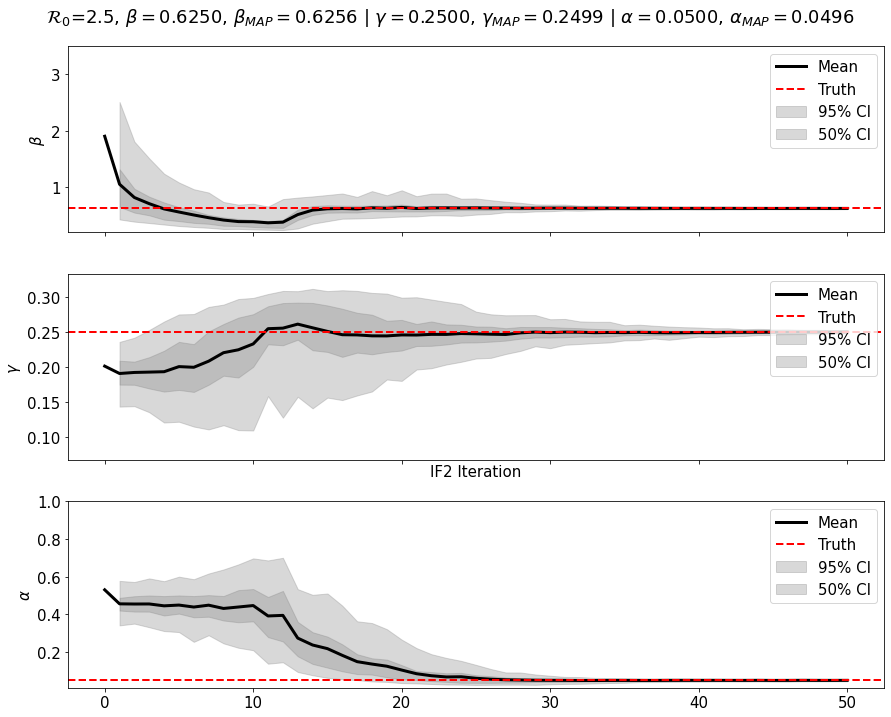

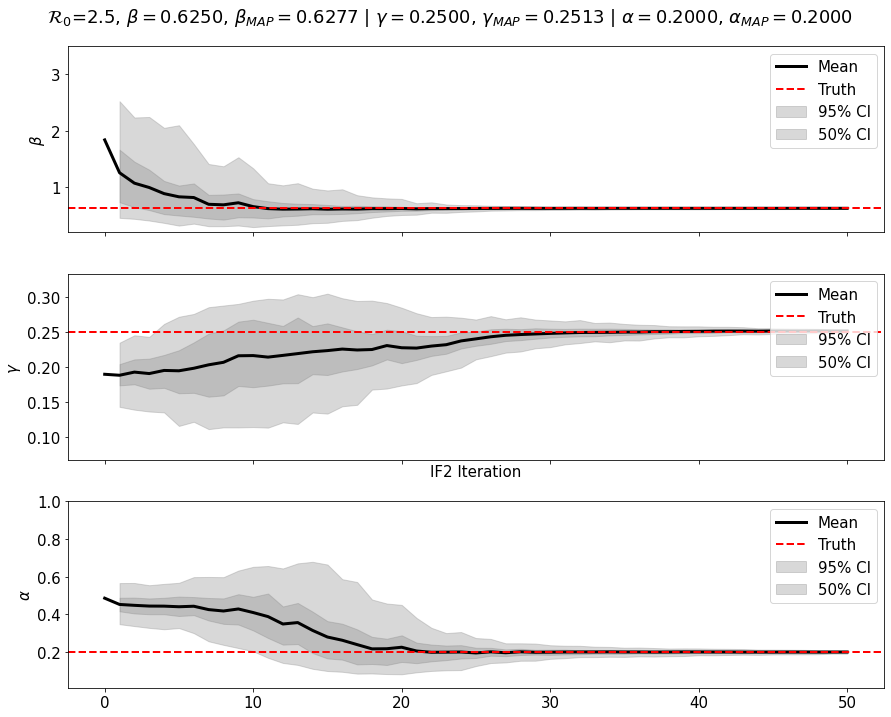

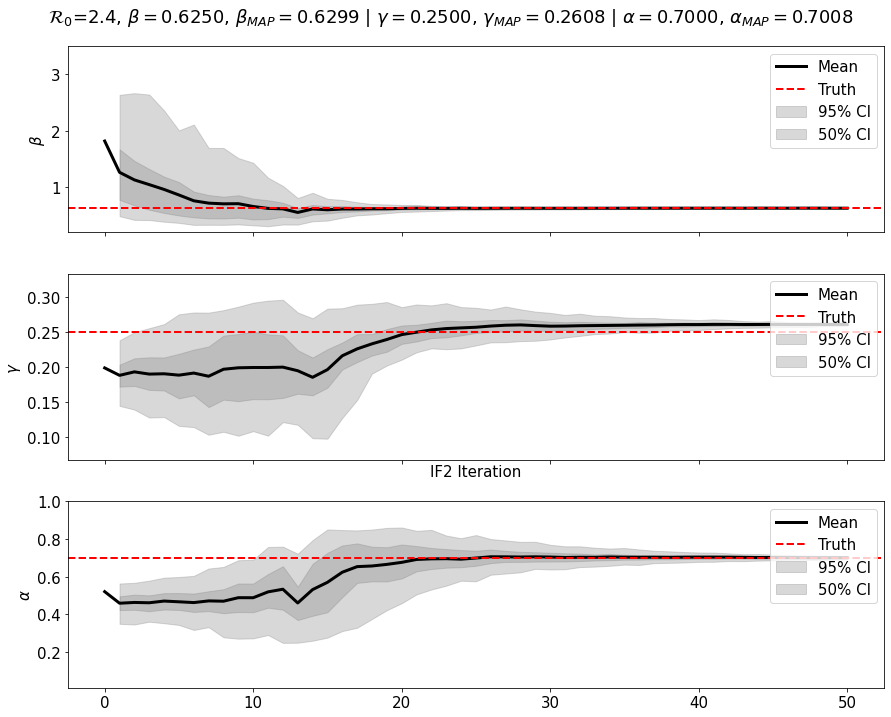

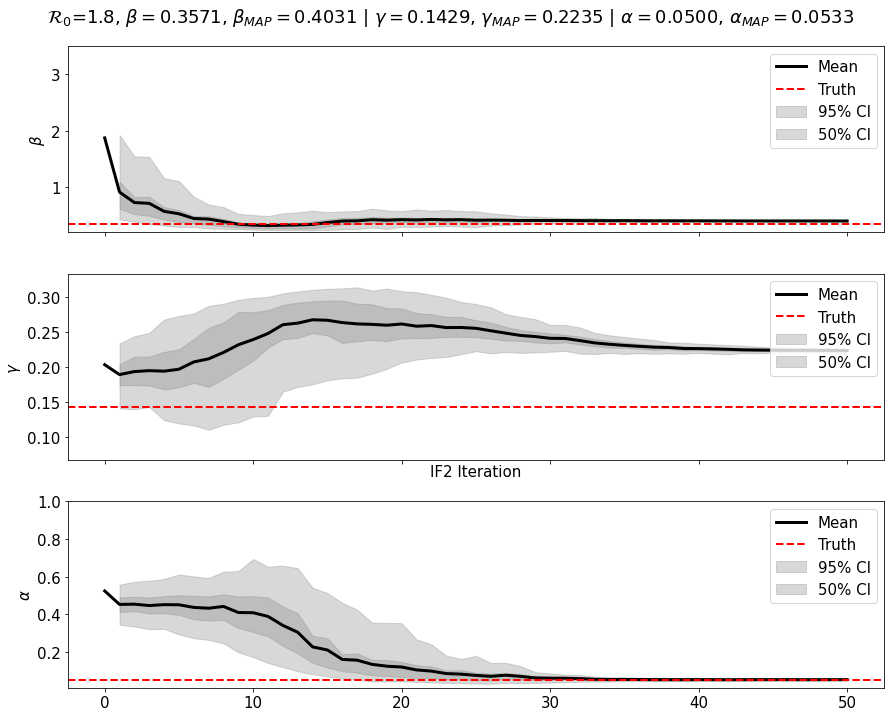

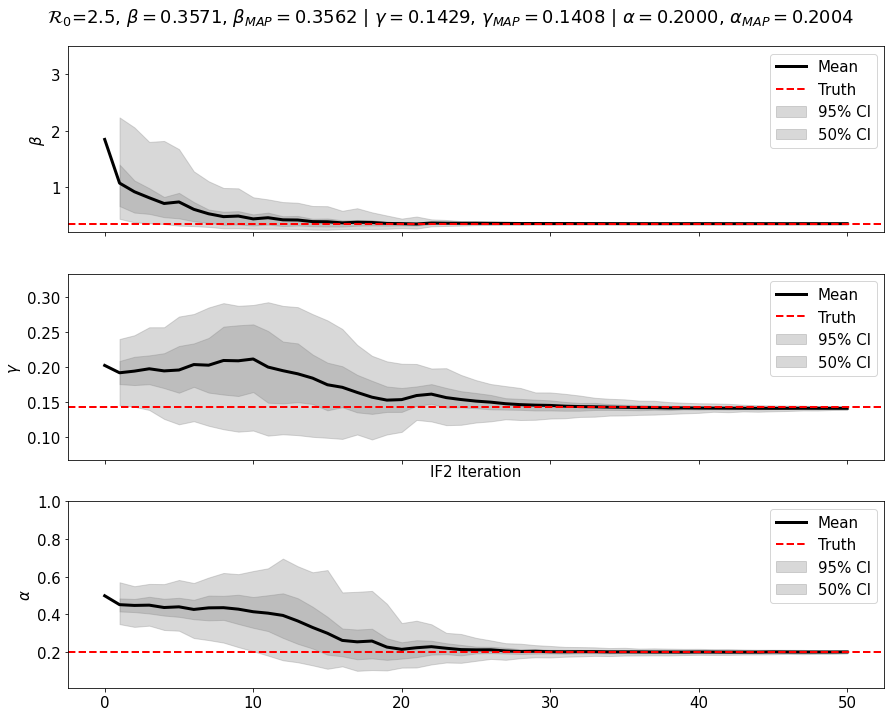

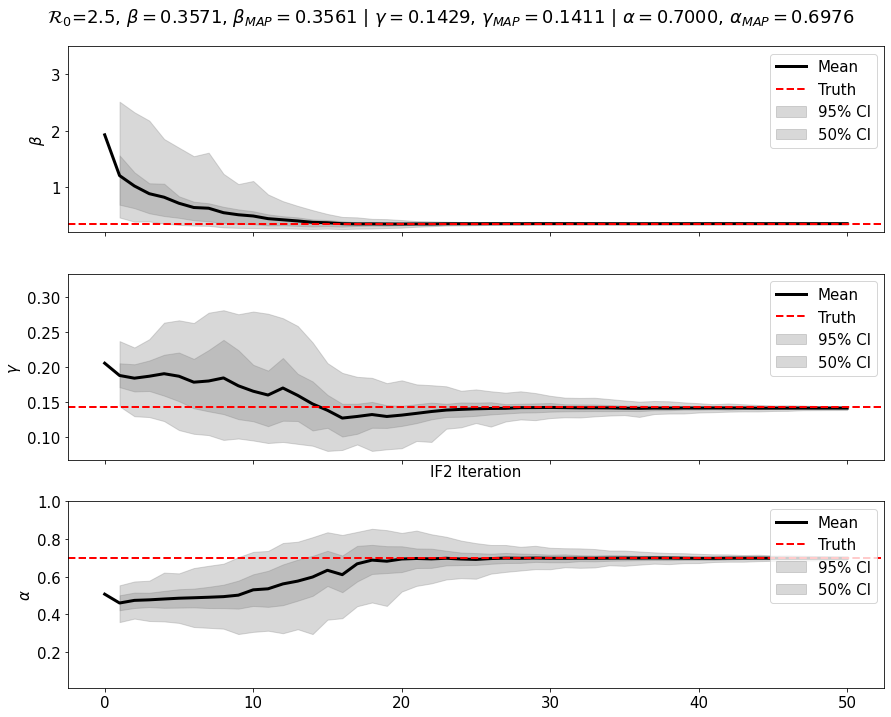

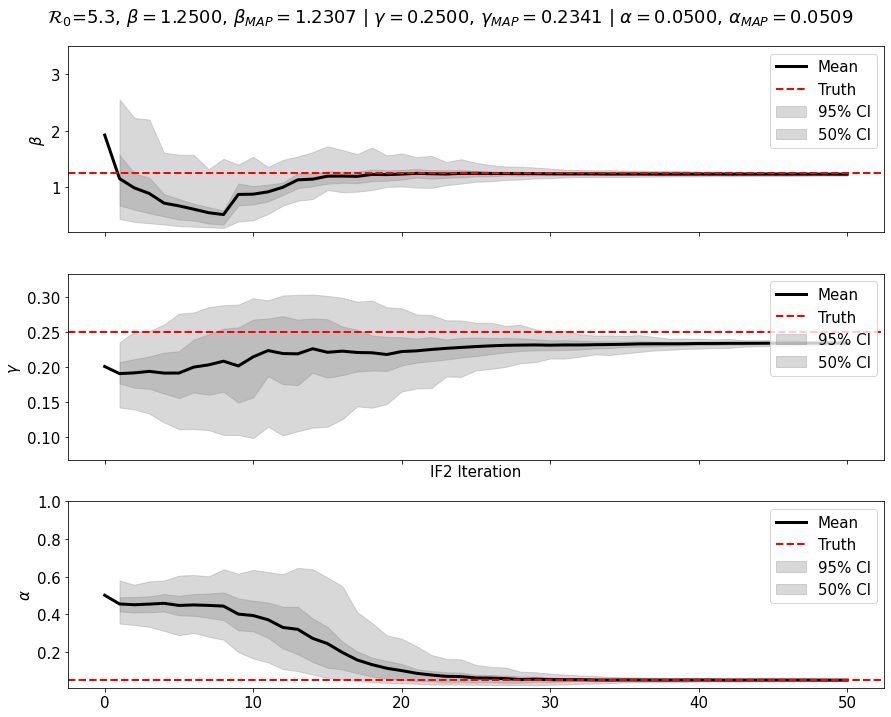

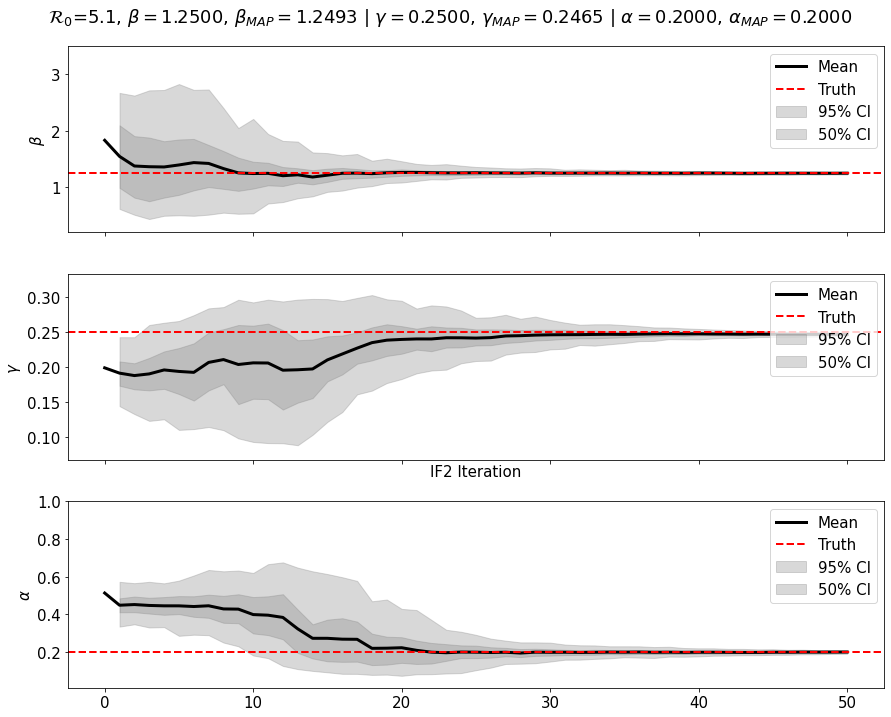

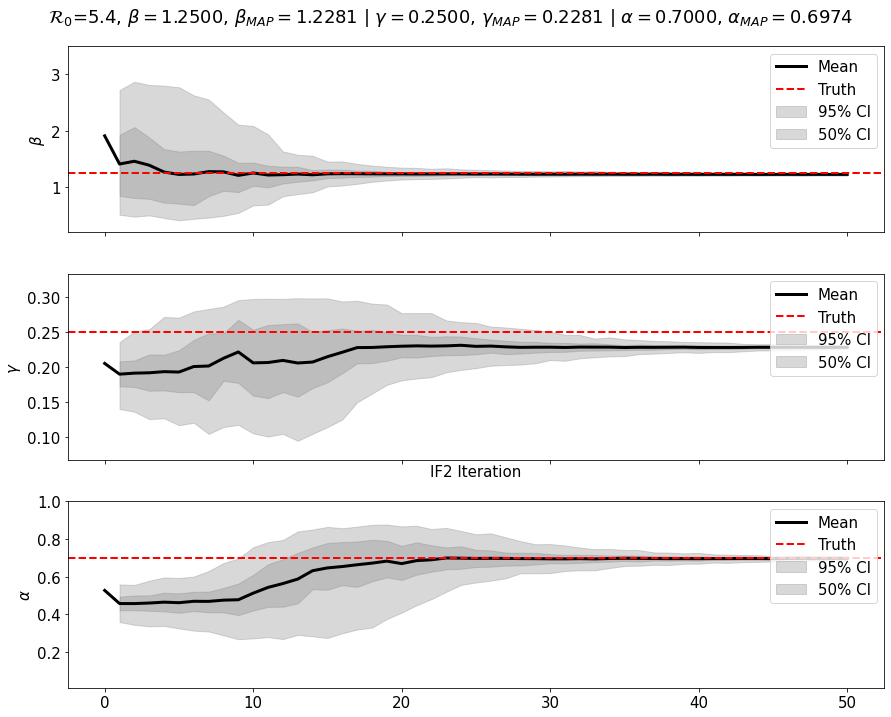

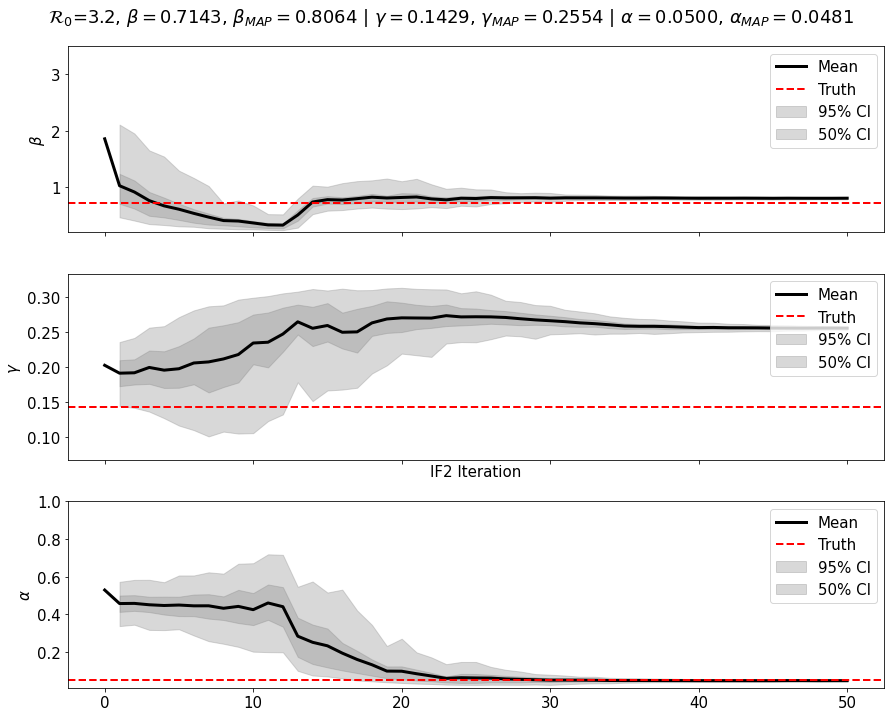

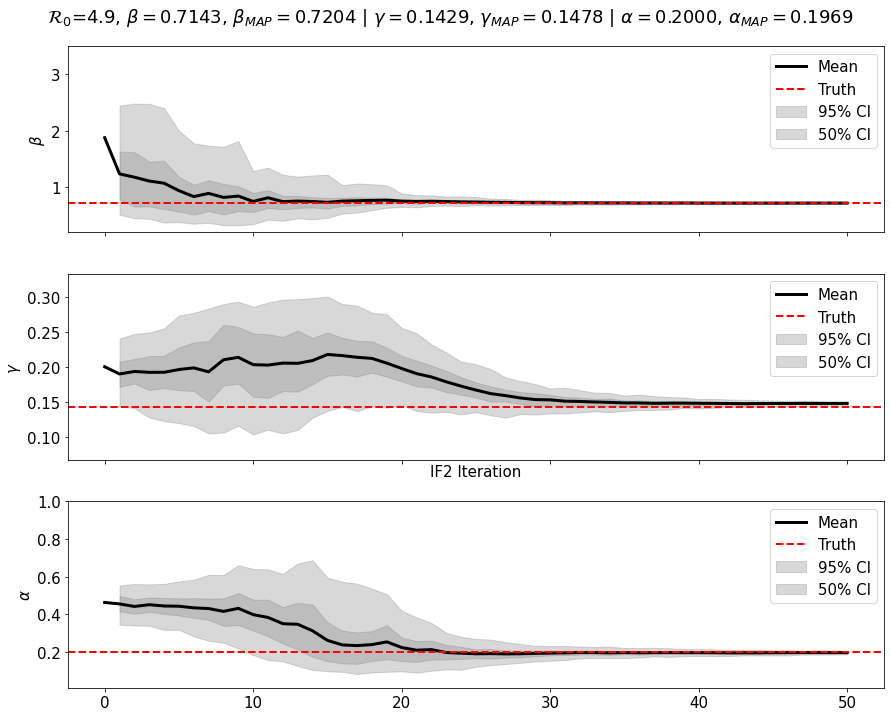

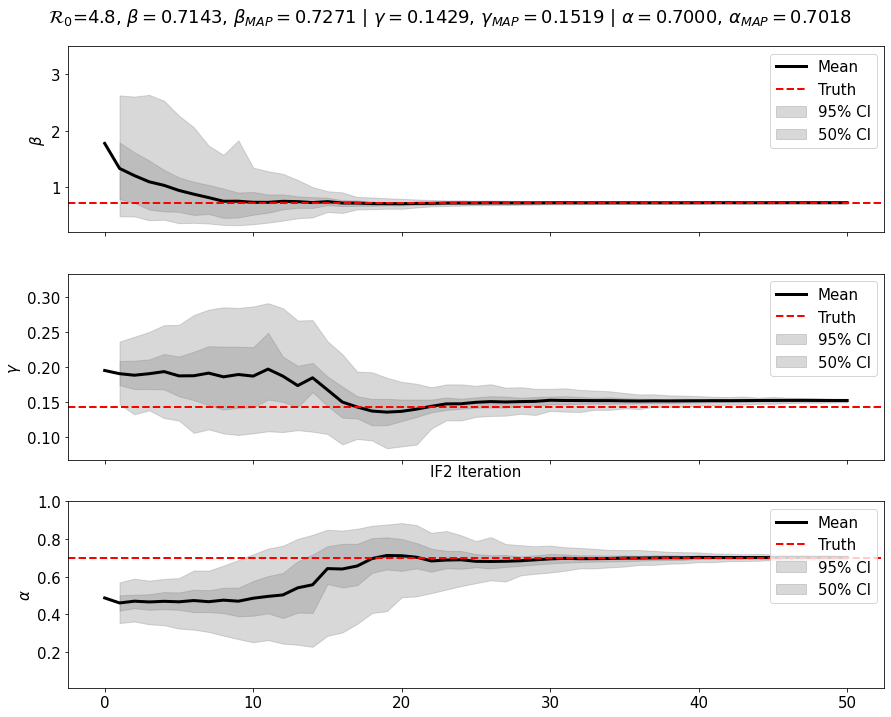

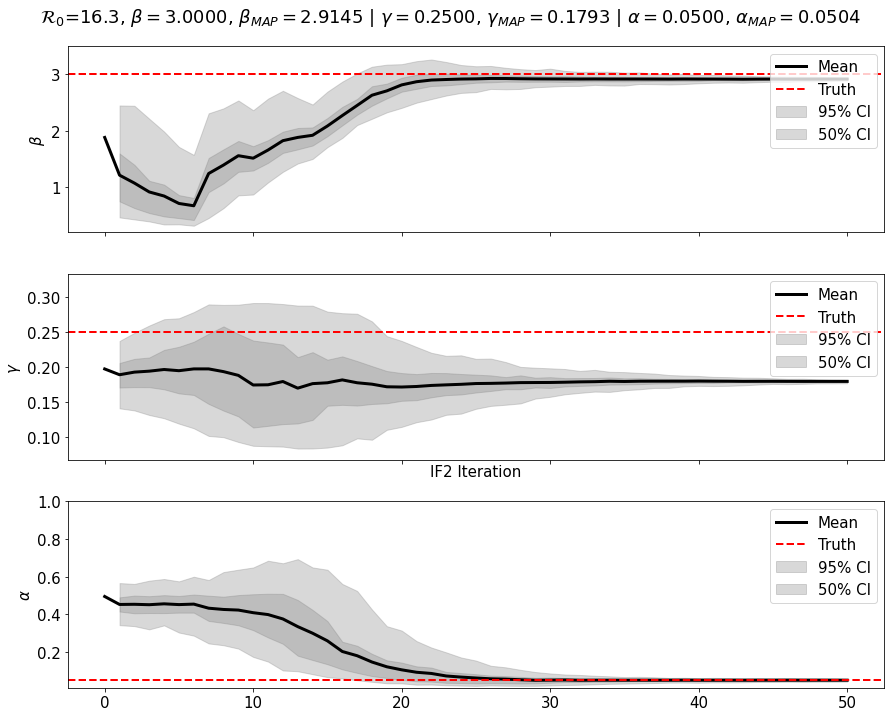

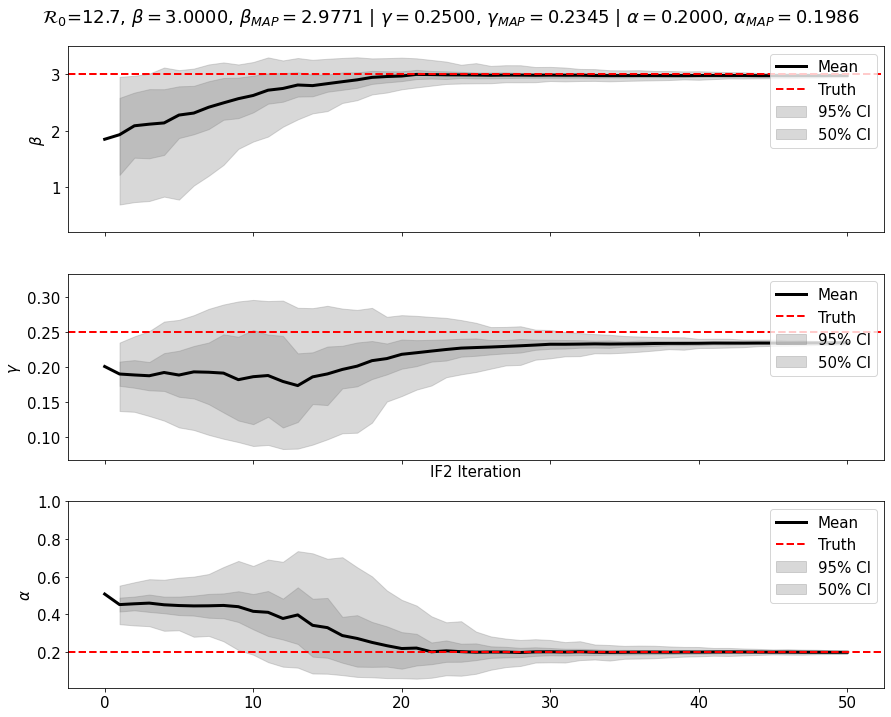

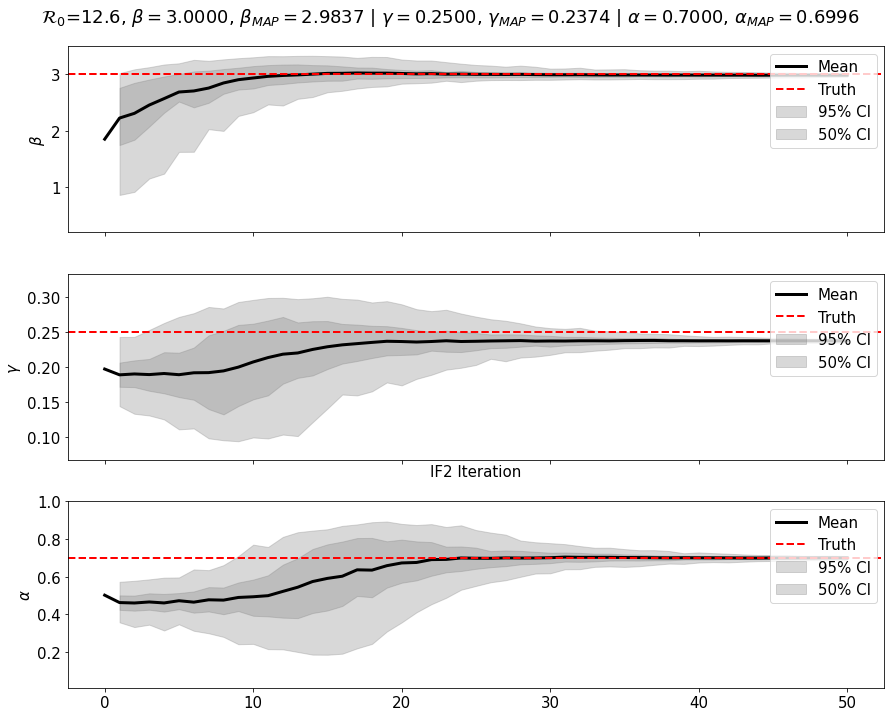

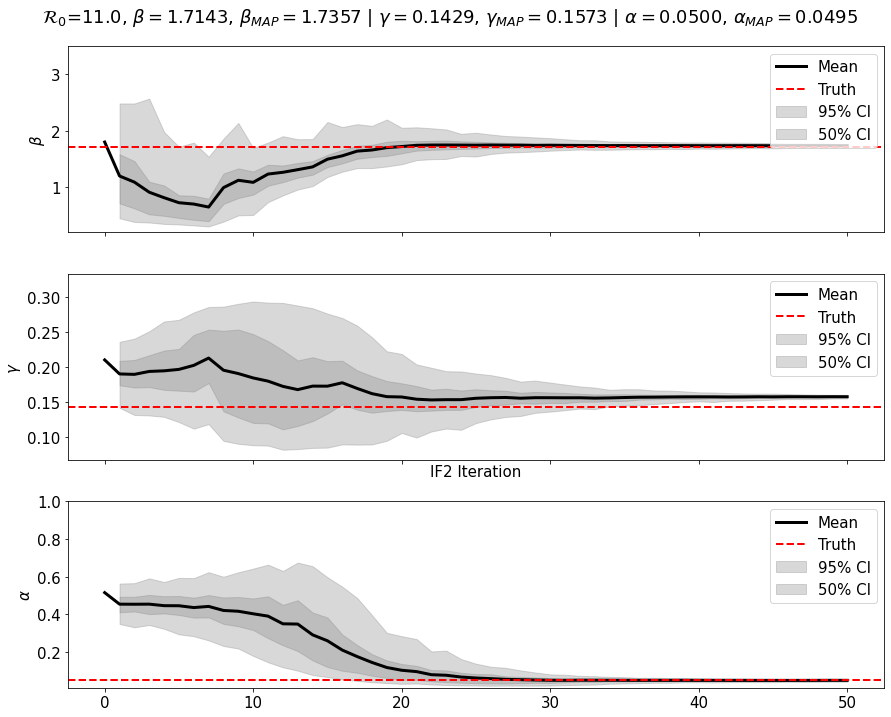

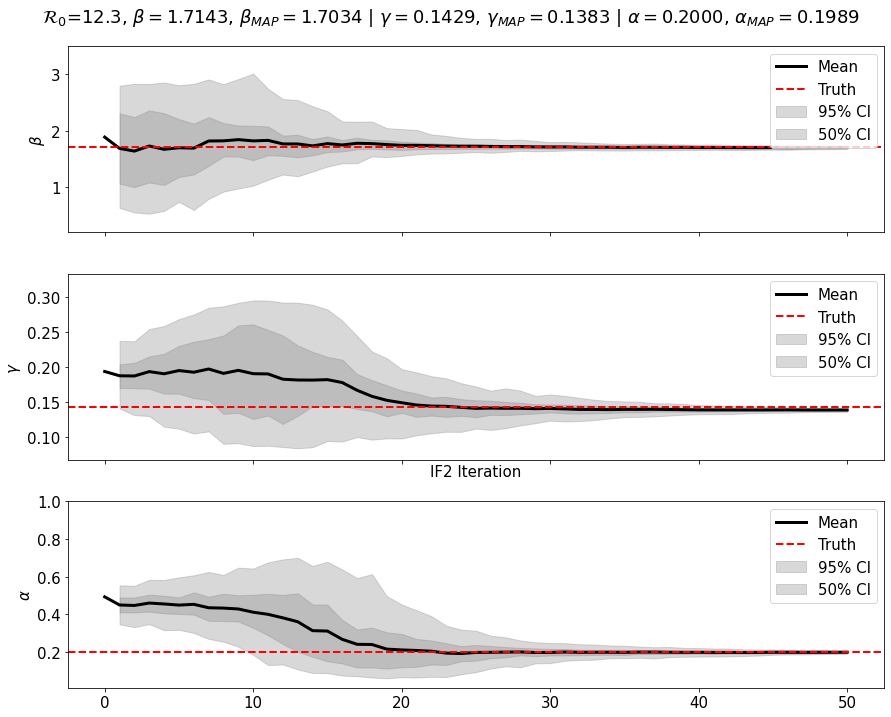

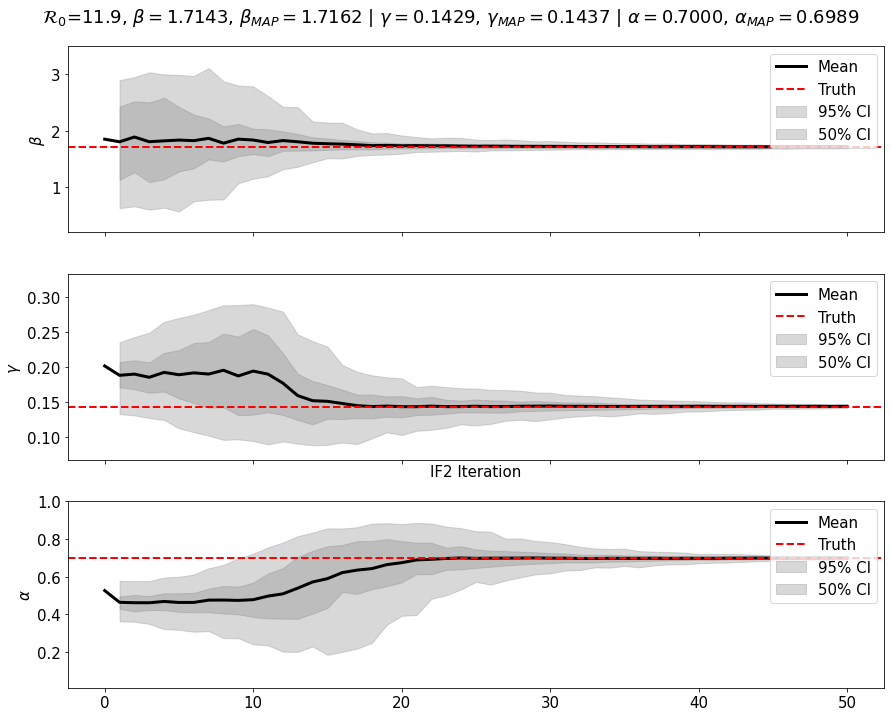

In [10]:
r_ceros     = [2.5, 5, 12]
gammas      = [1/4, 1/7]
report_rates = [0.05, 0.2, 0.7]
for R0 in r_ceros:
    for gamma in gammas:
        for report_rate in report_rates:
            beta  = R0*gamma

            N     = 1e6

            beta_truth        = beta
            gamma_truth       = gamma
            report_rate_truth = report_rate

            num_days = 100
            x  = [N-0.01*N, 0.01*N, 0, 0]

            x_sol      = np.zeros((num_days, 4))

            x_sol[0, :] = x
            for d_idx in range(1, num_days):
                x_sol[d_idx, :] = model(x_sol[d_idx-1, :], beta_truth, gamma_truth, report_rate_truth,  N)

            x_sol_df = pd.DataFrame(x_sol, columns=["S", "I", "R", "C"]); x_sol_df.index.name="date"

            obs_df         = x_sol_df[["C"]].rename(columns={"C": "confirmed"})
            oev_df         = pd.DataFrame(columns=["date", "oev"])
            oev_df["date"] = obs_df.index.values
            oev_df         = oev_df.set_index("date")
            oev_df["oev"]  = np.maximum(20,  1+(0.2*obs_df["confirmed"].values)**2  )


            param_prior_dict                = {}
            param_prior_dict["beta"]        = [0.2, 3.5]   # Contact rate         [1/days]
            param_prior_dict["gamma"]       = [1/15, 1/3]  # Recovery rate range  [1/days]
            param_prior_dict["report_rate"] = [0.01, 1]  # Recovery rate range  [1/days]

            params_type_dict  = {"beta": "log_transform", "gamma": "log_transform"} # Define type of transformation for estimate
            transform_dict    = {"beta": True, "gamma": True}                       # Define if tranform or nor parameters

            if2_settings = {}
            if2_settings["num_params"]       = len(param_prior_dict)
            if2_settings["num_state_vars"]   = 4
            if2_settings["num_observations"] = 1
            if2_settings["lambda_inf"]       = 1.01
            if2_settings["num_iters_mif"]    = 50
            if2_settings["alpha_mif"]        = 0.9 # Variance shrinking factor
            if2_settings["type_cooling"]     = "geometric"
            if2_settings["num_ensembles"]    = 300

            x_states_post_all, obs_post_all, para_post_all, param_iter, param_mean_iter = IF2_eakf(model, obs_df, param_prior_dict, if2_settings,  perturb_time=True)
            plot_convergence_plots2(param_mean_iter, param_iter, list(param_prior_dict.values()), path_to_save = os.path.join(results_dir, "if2_eakf", "sir_3params", "beta_{:.2f}_gamma_{:.2f}_reprate_{}.png".format(beta_truth, 1/gamma_truth, report_rate)))
